# Neural Network
---

With a basic linear model performing reasonably well at predicting a player's output for the following season, we'll now move to using a more complex model, specifically, the neural network. When we have a trained model, we'll use it to actually make predictions about player performances for the upcoming season.

### Import libraries
---

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Load the data
---

In [2]:
df = pd.read_csv('../data/clean.csv')
df.head()

,player,team,fantasy_pos,age,g,gs,pass_cmp,pass_att,pass_yds,pass_td,...,two_pt_pass,fantasy_points,fantasy_points_ppr,year,is_qb,is_rb,is_te,is_wr,fantasy_points_next_year,fantasy_points_ppr_next_year
0,Christian McCaffrey,CAR,RB,23,16.0,16.0,0.0,2.0,0.0,0.0,...,0.0,355.0,471.2,2019,0,1,0,0,NaN,NaN
1,Lamar Jackson,BAL,QB,22,15.0,15.0,265.0,401.0,3127.0,36.0,...,0.0,416.0,415.7,2019,1,0,0,0,NaN,NaN
2,Derrick Henry,TEN,RB,25,15.0,15.0,0.0,0.0,0.0,0.0,...,0.0,277.0,294.6,2019,0,1,0,0,NaN,NaN
3,Aaron Jones,GNB,RB,25,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,266.0,314.8,2019,0,1,0,0,NaN,NaN
4,Ezekiel Elliott,DAL,RB,24,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,258.0,311.7,2019,0,1,0,0,NaN,NaN


In [3]:
df.shape

(25080, 32)

In [4]:
# Create copy of dataframe with only 2019 data for future use in making predictions.
is_2019 = df['year'] == 2019
df_2019 = df.loc[is_2019, :].copy()

### Delete rows missing fantasy stats for next year
---

As we did with the linear model, we'll have to delete rows missing fantasy data for the following season.

In [5]:
no_stats_next_year = df.loc[df['fantasy_points_next_year'].isnull(), :].index
df.drop(index=no_stats_next_year, inplace=True)

# Predicting `fantasy_points_next_year`
---

### Set up X and y, train/test split
---

In [6]:
features = df.select_dtypes('number').columns.drop(['fantasy_points_next_year', 'fantasy_points_ppr_next_year'])

X = df[features]
y = df['fantasy_points_next_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Scale `X`
---

In [7]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

### Create network
---

In [8]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=Z_train[0].shape))
model.add(Dense(1, activation=None))

### Compile model
---

In [9]:
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Fit model
---

In [10]:
hist = model.fit(Z_train, y_train,
                 epochs=100,
                 batch_size=128,
                 validation_data=(Z_test, y_test),
                 verbose=0)

### Visualize model performance
---

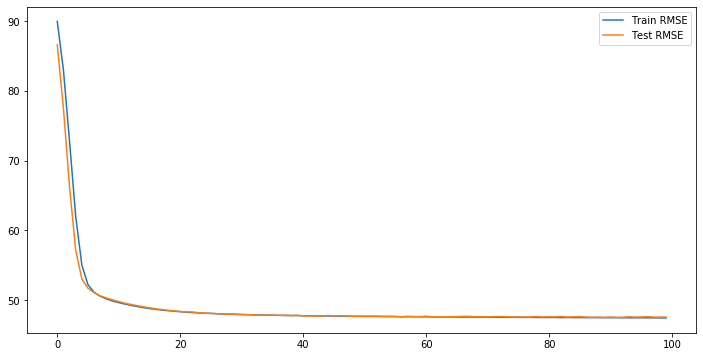

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(hist.history['val_root_mean_squared_error'], label='Test RMSE')
plt.legend();

### Making predictions for 2020
---

In [12]:
X = df_2019[features]
Z = ss.transform(X)

df_2019['fantasy_points_next_year'] = model.predict(Z)

# Predicting `fantasy_points_ppr_next_year`
---

### Set up X and y, train/test split
---

In [13]:
features = df.select_dtypes('number').columns.drop(['fantasy_points_next_year', 'fantasy_points_ppr_next_year'])

X = df[features]
y = df['fantasy_points_ppr_next_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Scale `X`
---

In [14]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

### Create network
---

In [15]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=Z_train[0].shape))
model.add(Dense(1, activation=None))

### Compile model
---

In [16]:
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Fit model
---

In [17]:
hist = model.fit(Z_train, y_train,
                 epochs=100,
                 batch_size=128,
                 validation_data=(Z_test, y_test),
                 verbose=0)

### Visualize model performance
---

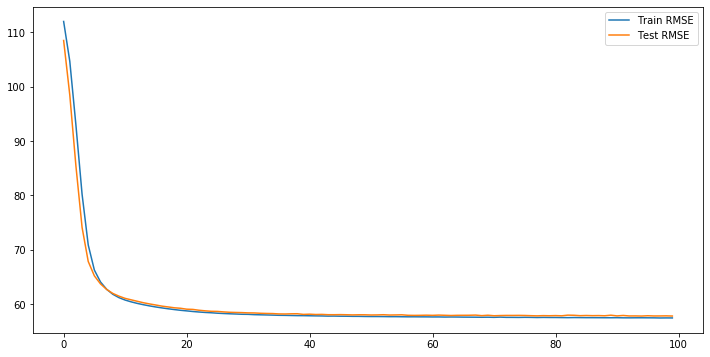

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(hist.history['val_root_mean_squared_error'], label='Test RMSE')
plt.legend();

### Making predictions for 2020
---

In [19]:
X = df_2019[features]
Z = ss.transform(X)

df_2019['fantasy_points_ppr_next_year'] = model.predict(Z)

# Export predictions for next year
---

In [20]:
try:
    os.mkdir('../data')
except FileExistsError:
    pass
finally:
    try:
        os.mkdir('../data/2020-projections')
    except FileExistsError:
        pass

In [21]:
# Export RB projections.
rb_2020 = df_2019.loc[df_2019['is_rb'] == 1, ['player', 'fantasy_points_next_year', 'fantasy_points_ppr_next_year']]
rb_2020.sort_values(by='fantasy_points_ppr_next_year', ascending=False, inplace=True)
rb_2020.to_csv('../data/2020-projections/rb.csv', index=False)

In [22]:
# Export QB projections.
qb_2020 = df_2019.loc[df_2019['is_qb'] == 1, ['player', 'fantasy_points_next_year', 'fantasy_points_ppr_next_year']]
qb_2020.sort_values(by='fantasy_points_ppr_next_year', ascending=False, inplace=True)
qb_2020.to_csv('../data/2020-projections/qb.csv', index=False)

In [23]:
# Export WR projections.
wr_2020 = df_2019.loc[df_2019['is_wr'] == 1, ['player', 'fantasy_points_next_year', 'fantasy_points_ppr_next_year']]
wr_2020.sort_values(by='fantasy_points_ppr_next_year', ascending=False, inplace=True)
wr_2020.to_csv('../data/2020-projections/wr.csv', index=False)

In [24]:
# Export TE projections.
te_2020 = df_2019.loc[df_2019['is_te'] == 1, ['player', 'fantasy_points_next_year', 'fantasy_points_ppr_next_year']]
te_2020.sort_values(by='fantasy_points_ppr_next_year', ascending=False, inplace=True)
te_2020.to_csv('../data/2020-projections/te.csv', index=False)